# Capstone Project - The Battle of Neighborhoods 
by Hui Jen Yee

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find a suitable idea for what kind of restaurant should be opened at desired location. Specifically, this report will be targeted to stakeholders interested in opening a restaurant in **Kuala Lumpur, Malaysia**.

Malaysia is a multi–ethnic, multicultural, and multilingual society, and the many ethnic groups in Malaysia maintain separate cultural identities. Whereas Kuala Lumpur as the national city of Malaysia, has a high population and population density. Therefore we will try to detect which geographical area has **the majority ethnic group**, and at the same time are not already crowded with restaurants. We would also prefer locations **as close to city center as possible**.


We will use our data science powers to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed by maps and information charts so that best possible final location can be chosen by stakeholders. 

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* Majority ethnic group in the neighborhood
* Number of existing restaurants in the neighborhood (any type of restaurant)

List of data sources:
* Demographic information of ethnic groups in Kuala Lumpur are found on TindakMalaysia Website
* Coordinates of Kuala Lumpur center are obtained using **Geocoders geocoding API** of well known Kuala Lumpur location 
* Neighborhood areas of Kuala Lumpur are found on TindakMalaysia Github Repository
* Coordinates of centers of candidate areas are generated mathematically from the neighborhood areas of Kuala Lumpur
* Number of restaurants and their type and location in every neighborhood are obtained using **Foursquare API**


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import statistics

print('Libraries imported.')

Libraries imported.


IBM Cloud Object Storage credentials are defined in hidden cell bellow.

In [2]:
# The code was removed by Watson Studio for sharing.

### Demographic Data

First, let's scrape Kuala Lumpur's demographic information from [TindakMalaysia](http://tindakmalaysia.org/). This information is based on data source Q4, Year 2017. Kuala Lumpur has totally 11 districts. Ethnic groups are listed according to their percentage for each district.   

In [3]:
download_file_cos(credentials_1,"KL_Ethnic_Percent_Q4_2017.xlsx","KL_Ethnic_Percent_Q4_2017.xlsx")

KL_ethnic = pd.read_excel('KL_Ethnic_Percent_Q4_2017.xlsx')
KL_ethnic['District'] = KL_ethnic['District'].str.upper()
KL_ethnic

File Downloaded


,District,Chinese,Malay,India,Bumiputera Sabah,Bumiputera Sarawak,Orang Asli,Others
0,BANDAR TUN RAZAK,29.10,61.10,8.27,0.42,0.53,0.01,0.57
1,BATU,38.27,42.52,17.47,0.32,0.44,0.02,0.96
2,BUKIT BINTANG,75.13,12.53,10.95,0.37,0.28,0.02,0.73
3,CHERAS,82.93,9.66,6.74,0.22,0.06,0.01,0.38
4,KEPONG,88.74,4.56,6.03,0.30,0.05,NaN,0.32
5,LEMBAH PANTAI,18.91,62.11,16.26,0.67,0.48,0.02,1.55
6,SEGAMBUT,58.91,27.53,11.78,0.14,0.12,0.01,1.50
7,SEPUTEH,82.02,9.04,7.88,0.22,0.08,NaN,0.75
8,SETIAWANGSA,25.87,61.08,10.39,0.75,1.08,0.04,0.78
9,TITIWANGSA,17.31,70.48,9.42,0.49,0.37,0.01,1.91


We only wish to find out the majority ethnic in each district area. Let's add a column of 'Majority Race', and remove other redundant information.

In [4]:
KL_ethnic['Majority Race'] = KL_ethnic.iloc[:,1:].idxmax(1)
KL_ethnic['Percentage'] = KL_ethnic.max(1) 

KL_ethnic = KL_ethnic[['District', 'Majority Race', 'Percentage']]
KL_ethnic

,District,Majority Race,Percentage
0,BANDAR TUN RAZAK,Malay,61.10
1,BATU,Malay,42.52
2,BUKIT BINTANG,Chinese,75.13
3,CHERAS,Chinese,82.93
4,KEPONG,Chinese,88.74
5,LEMBAH PANTAI,Malay,62.11
6,SEGAMBUT,Chinese,58.91
7,SEPUTEH,Chinese,82.02
8,SETIAWANGSA,Malay,61.08
9,TITIWANGSA,Malay,70.48


In order to create a Cholopeth map of Kuala Lumpur to show the demographic information, let's create another column of 'Majority Race No' so that **ethnic groups** are represented as **numbers**.

In [5]:
KL = KL_ethnic['Majority Race'].copy()
KL_ethnic.insert(3, 'Majority Race No', KL)
KL_ethnic['Majority Race No'] = KL_ethnic['Majority Race No'].replace({'Malay':0, 'Chinese':1})
KL_ethnic

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,District,Majority Race,Percentage,Majority Race No
0,BANDAR TUN RAZAK,Malay,61.10,0
1,BATU,Malay,42.52,0
2,BUKIT BINTANG,Chinese,75.13,1
3,CHERAS,Chinese,82.93,1
4,KEPONG,Chinese,88.74,1
5,LEMBAH PANTAI,Malay,62.11,0
6,SEGAMBUT,Chinese,58.91,1
7,SEPUTEH,Chinese,82.02,1
8,SETIAWANGSA,Malay,61.08,0
9,TITIWANGSA,Malay,70.48,0


Let's find Latitude & Longitude of Kuala Lumpur city center using specific, well known address and Geocoders geocoding API.

In [6]:
address = 'Kuala Lumpur, Malaysia'

geolocator = Nominatim(user_agent="kl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Kuala Lumpur, Malaysia are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Kuala Lumpur, Malaysia are 3.1516636, 101.6943028.


Next,

Let's scrape Coordinates of Neighborhoods in Kuala Lumpur from [TindakMalaysia Github Repository](https://github.com/TindakMalaysia/Federal-Territories-Maps/tree/master/KL/) 

In [7]:
download_file_cos(credentials_2,"Kuala_Lumpur_map.json","Kuala_Lumpur_map.json")

with open('Kuala_Lumpur_map.json') as json_data:
    KL_data = json.load(json_data)
KL_data

File Downloaded


{'crs': {'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'},
  'type': 'name'},
 'features': [{'geometry': {'coordinates': [[[101.6585629090845,
       3.113126779727183],
      [101.65351386912528, 3.109942613531056],
      [101.65248043989386, 3.110443825514589],
      [101.65227375404757, 3.111298833642442],
      [101.6512993779151, 3.11389333681888],
      [101.6506202672773, 3.11572127840115],
      [101.64985257699112, 3.1170480082067],
      [101.64849435571554, 3.117961976655115],
      [101.64698850169262, 3.117961976655115],
      [101.64441969188879, 3.118227322184957],
      [101.64359294850365, 3.118979134155917],
      [101.64362247505312, 3.120541722022768],
      [101.6476676123304, 3.125111541126676],
      [101.6480514574735, 3.126025502560403],
      [101.64778571852827, 3.126939463197935],
      [101.64639797070322, 3.128089283513827],
      [101.64725424063784, 3.12888531222461],
      [101.64799240437455, 3.129769787860873],
      [101.6482286167703, 3.13038

Let's transform Kuala Lumpur Map's Json data into pandas dataframe for easy reading. 

We estimated the Centers of Neighborhoods by calculate them algorithmically from the coordinates of boundaries of each neighborhoods.

In [8]:
# define the dataframe columns
column_names = ['District', 'Latitude', 'Longitude'] 

# instantiate the dataframe
KL = pd.DataFrame(columns=column_names)

In [9]:
for data in KL_data['features']:
    lat_list =[]
    lon_list =[]
    district = data['properties']['Parliament']         
    coordinates = data['geometry']['coordinates'][0]
    for coor in coordinates:
        lat = coor[1]
        lon = coor[0]
        lat_list.append(lat)
        lon_list.append(lon)
    
    center_lat = statistics.mean(lat_list)
    center_lon = statistics.mean(lon_list)

    KL = KL.append({'District': district,
                      'Latitude': center_lat,
                      'Longitude': center_lon}, ignore_index=True)
KL

,District,Latitude,Longitude
0,LEMBAH PANTAI,3.109179,101.664066
1,TITIWANGSA,3.156350,101.719261
2,CHERAS,3.116632,101.726023
3,SETIAWANGSA,3.185183,101.733304
4,BUKIT BINTANG,3.139090,101.700725
5,BATU,3.202750,101.681007
6,KEPONG,3.207030,101.652003
7,SEPUTEH,3.088583,101.690155
8,SEGAMBUT,3.166146,101.657389
9,WANGSA MAJU,3.210742,101.720206


Let's make some adjustments for centers of neighborhoods since neighborhood areas are usually in irregular shapes and therefore their centers are placed far from the middle of area.

In [10]:
#coordinates obtained using Google Maps

KL.loc[KL.index[2], 'Latitude'] = 3.098256     #cheras 
KL.loc[KL.index[2], 'Longitude'] = 101.734837
KL.loc[KL.index[1], 'Latitude'] = 3.153691     #titiwangsa
KL.loc[KL.index[1], 'Longitude'] = 101.736048

KL

,District,Latitude,Longitude
0,LEMBAH PANTAI,3.109179,101.664066
1,TITIWANGSA,3.153691,101.736048
2,CHERAS,3.098256,101.734837
3,SETIAWANGSA,3.185183,101.733304
4,BUKIT BINTANG,3.139090,101.700725
5,BATU,3.202750,101.681007
6,KEPONG,3.207030,101.652003
7,SEPUTEH,3.088583,101.690155
8,SEGAMBUT,3.166146,101.657389
9,WANGSA MAJU,3.210742,101.720206


Let's combine both tables obtained so far for easy reading.

In [11]:
KL = KL.join(KL_ethnic.set_index('District'), on='District')
KL

,District,Latitude,Longitude,Majority Race,Percentage,Majority Race No
0,LEMBAH PANTAI,3.109179,101.664066,Malay,62.11,0
1,TITIWANGSA,3.153691,101.736048,Malay,70.48,0
2,CHERAS,3.098256,101.734837,Chinese,82.93,1
3,SETIAWANGSA,3.185183,101.733304,Malay,61.08,0
4,BUKIT BINTANG,3.139090,101.700725,Chinese,75.13,1
5,BATU,3.202750,101.681007,Malay,42.52,0
6,KEPONG,3.207030,101.652003,Chinese,88.74,1
7,SEPUTEH,3.088583,101.690155,Chinese,82.02,1
8,SEGAMBUT,3.166146,101.657389,Chinese,58.91,1
9,WANGSA MAJU,3.210742,101.720206,Malay,59.81,0


#### Map of Kuala Lumpur with neighborhoods, demography and radius coverage for each center superimposed on top.

Let's visualize the data we have so far. 
We will use python folium library to visualize geographic details of Kuala Lumpur and with its districts superimposed on top. Latitude and longitude values are used to create the map below.

At the same time, let's add circles to the map to show the area coverage of specific radius from centers of districts that will be utilized by Foursquare API when searching for venues later.

In [12]:
map_kl = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson(
    'Kuala_Lumpur_map.json',
    name='geojson'
).add_to(map_kl)

map_kl.choropleth(
    geo_data=KL_data,
    data=KL,
    columns=['District', 'Majority Race No'],
    key_on='feature.properties.Parliament',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Race: 0 as Malay, 1 as Chinese'
)

# add circles to map to show the areas that will be covered by Foursquare API when searching for venues
for lat, lng, label in zip(KL['Latitude'], KL['Longitude'], KL['District']):
    folium.Circle(
        [lat,lng],
        radius=1100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kl)  

map_kl

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood. 

First we explore the venues nearby in each neigborhood using their latitudes and longitudes. We will only search for venues under 'food' category. The code for 'food category' can be found on Foursquare Documentation. The limit is set as 100 venues and the radius as 1100 meter for each borough from their given latitude and longitude information. 

Foursquare credentials are defined in hidden cell bellow.

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            item['venue']['name'],
            item['venue']['categories'][0]['name'],
            (item['venue']['location']['lat'], item['venue']['location']['lng']),
            item['venue']['location']['distance']) for item in results])  

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                             'Venue Name',
                             'Venue Category',
                             'Venue Coordinates',
                             'Venue Distance'
                            ]
    
    return(nearby_venues)


In [15]:
kl_venues = getNearbyVenues(names=KL['District'],
                            latitudes=KL['Latitude'],
                            longitudes=KL['Longitude'],
                            category='4d4b7105d754a06374d81259', # Food Category
                            client_id=CLIENT_ID,
                            client_secret=CLIENT_SECRET,
                            radius=1100, 
                            limit=100
                                  )

LEMBAH PANTAI
TITIWANGSA
CHERAS
SETIAWANGSA
BUKIT BINTANG
BATU
KEPONG
SEPUTEH
SEGAMBUT
WANGSA MAJU
BANDAR TUN RAZAK


In [16]:
print(kl_venues.shape)
kl_venues.head(5)

(868, 5)


,District,Venue Name,Venue Category,Venue Coordinates,Venue Distance
0,LEMBAH PANTAI,明記家鄉小食,Chinese Restaurant,"(3.1104848185266993, 101.678110759793)",271
1,LEMBAH PANTAI,Nihon Kai,Japanese Restaurant,"(3.106273820844563, 101.67897077220967)",349
2,LEMBAH PANTAI,Sanuki Udon,Udon Restaurant,"(3.110877105565396, 101.68498225960003)",566
3,LEMBAH PANTAI,BBQ Thai,Thai Restaurant,"(3.108597763859346, 101.67889235460834)",156
4,LEMBAH PANTAI,Gyutaro Yakiniku,Japanese Restaurant,"(3.1041169632637438, 101.6777439142475)",624


We're interested in venues in 'food' category, but only those that are proper restaurants. So let's filter the list to only include the venues that have 'restaurant' in category name after getting the result from Foursquare.

In [17]:
kl_restaurants = kl_venues[kl_venues['Venue Category'].str.contains("Restaurant")]
kl_restaurants.head(5)

,District,Venue Name,Venue Category,Venue Coordinates,Venue Distance
0,LEMBAH PANTAI,明記家鄉小食,Chinese Restaurant,"(3.1104848185266993, 101.678110759793)",271
1,LEMBAH PANTAI,Nihon Kai,Japanese Restaurant,"(3.106273820844563, 101.67897077220967)",349
2,LEMBAH PANTAI,Sanuki Udon,Udon Restaurant,"(3.110877105565396, 101.68498225960003)",566
3,LEMBAH PANTAI,BBQ Thai,Thai Restaurant,"(3.108597763859346, 101.67889235460834)",156
4,LEMBAH PANTAI,Gyutaro Yakiniku,Japanese Restaurant,"(3.1041169632637438, 101.6777439142475)",624


So now we have all the restaurants that are in vicinity of every neighborhood candidate center of Kuala Lumpur. 

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on the suggestion a suitable restaurant!

## Methodology <a name="methodology"></a>

In first step we have collected the required data: **location and type (category) of every restaurant within Kuala Lumpur center** . We have also **identified major ethnic group** on each neighborhood.

Second step in our analysis will be calculation and exploration of '**restaurant density**' across different areas of Kuala lumpur - we will use bar chart to identify promising areas which are close to centers with number and type of restaurants in general.

Next, we will present a map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones or neighborhoods which should be a starting point for final exploration and searching for optimal venue location by stakeholders.

### Number of Restaurants in each district area

Let's calculate the number of restaurants for each district area.

In [18]:
kl_res_count = kl_restaurants[['District','Venue Category']].groupby('District').count()
kl_res_count.sort_values(by=['Venue Category'],axis=0, ascending=False, inplace=True)
kl_res_count.rename(columns={'Venue Category': 'Number of Restaurants'}, inplace=True)
kl_res_count

,Number of Restaurants
District,
SEPUTEH,77
SETIAWANGSA,75
BANDAR TUN RAZAK,74
CHERAS,72
BATU,58
LEMBAH PANTAI,58
KEPONG,56
BUKIT BINTANG,47
WANGSA MAJU,40


Let's visualize the number of restaurants on each district area.

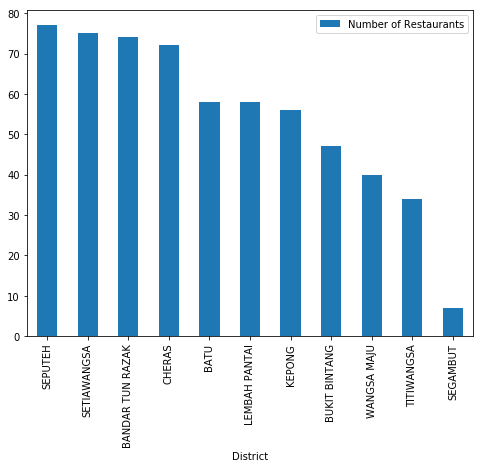

In [19]:
kl_res_count.plot(kind='bar', figsize=(8,6))

From the figure, we can see that Seputeh, Setiawangsa, Bandar Tun Razak, Cheras, Batu, Lembah Pantai, and Kepong have at least 55 restaurants. On the other hand, Bukit Bintang, Wangsa Maju and Titiwangsa  has slightly less restaurants which is around 30 to 50 restaurants. Segambut has the least number of restaurants which is below 10. 

However, the result doesn’t mean that all the possible results are listed out for each area. It depends on given latitude and longitude information of the city centers which are merely estimated by calculation or visual adjustment for each borough. More possibilities with neighborhood information can be obtained with more coordinates information, or the actual information about locations of centers of neighborhoods.



In [20]:
print('There are {} uniques categories.'.format(len(kl_restaurants['Venue Category'].unique())))

There are 38 uniques categories.


Since there are 38 unique categories returned by Foursquare, let's create a table to show the list of unique restaurant categories for each district.

In [21]:
# one hot encoding
kl_onehot = pd.get_dummies(kl_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kl_onehot['District'] = kl_restaurants['District'] 

# move neighborhood column to the first column
fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1]) 
kl_onehot = kl_onehot[fixed_columns]

kl_onehot.head()

,District,African Restaurant,American Restaurant,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,English Restaurant,Fast Food Restaurant,French Restaurant,Hakka Restaurant,Halal Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pakistani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,LEMBAH PANTAI,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LEMBAH PANTAI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LEMBAH PANTAI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,LEMBAH PANTAI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,LEMBAH PANTAI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
kl_onehot.shape

(598, 39)

In [23]:
kl_grouped = kl_onehot.groupby('District').mean().reset_index()   
kl_grouped

,District,African Restaurant,American Restaurant,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,English Restaurant,Fast Food Restaurant,French Restaurant,Hakka Restaurant,Halal Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pakistani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,BANDAR TUN RAZAK,0.000000,0.013514,0.121622,0.040541,0.540541,0.000000,0.027027,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.013514,0.027027,0.000000,0.000000,0.013514,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.040541,0.000000,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,0.000000,0.054054,0.013514
1,BATU,0.000000,0.000000,0.224138,0.017241,0.396552,0.017241,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.137931,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.051724,0.000000
2,BUKIT BINTANG,0.021277,0.021277,0.063830,0.000000,0.106383,0.000000,0.021277,0.000000,0.021277,0.042553,0.000000,0.000000,0.000000,0.000000,0.000000,0.191489,0.021277,0.021277,0.063830,0.042553,0.000000,0.106383,0.021277,0.000000,0.021277,0.021277,0.000000,0.063830,0.000000,0.042553,0.021277,0.000000,0.000000,0.042553,0.021277,0.000000,0.000000,0.000000
3,CHERAS,0.000000,0.000000,0.125000,0.000000,0.375000,0.013889,0.013889,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.125000,0.041667,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.027778,0.000000,0.000000,0.000000,0.000000,0.069444,0.000000,0.000000,0.055556,0.000000
4,KEPONG,0.000000,0.000000,0.250000,0.017857,0.285714,0.017857,0.000000,0.000000,0.017857,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.017857,0.160714,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.053571,0.000000
5,LEMBAH PANTAI,0.000000,0.000000,0.086207,0.017241,0.224138,0.000000,0.000000,0.000000,0.017241,0.000000,0.017241,0.017241,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.189655,0.017241,0.000000,0.086207,0.000000,0.000000,0.000000,0.000000,0.000000,0.068966,0.034483,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.017241,0.086207,0.017241
6,SEGAMBUT,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,SEPUTEH,0.012987,0.000000,0.155844,0.000000,0.493506,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.012987,0.025974,0.012987,0.000000,0.012987,0.012987,0.025974,0.051948,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.051948,0.012987,0.000000,0.012987,0.012987,0.012987,0.012987,0.000000,0.000000,0.012987,0.012987
8,SETIAWANGSA,0.000000,0.000000,0.186667,0.000000,0.306667,0.013333,0.026667,0.000000,0.013333,0.000000,0.000000,0.013333,0.000000,0.000000,0.000000,0.173333,0.000000,0.000000,0.000000,0.000000,0.000000,0.053333,0.000000,0.000000,0.013333,0.000000,0.013333,0.080000,0.026667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.013333,0.000000
9,TITIWANGSA,0.000000,0.000000,0.176471,0.0

### Top 10 restaurants in each district area

Let's create a table which shows list of top 10 restaurants for each district.

In [24]:
def return_most_common_res(row, num_top_res): 
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_res]

In [25]:
num_top_res = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_res):  
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind])) 
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1)) 

# create a new dataframe
district_res_sorted = pd.DataFrame(columns=columns)
district_res_sorted['District'] = kl_grouped['District']

for ind in np.arange(kl_grouped.shape[0]): 
    district_res_sorted.iloc[ind, 1:] = return_most_common_res(kl_grouped.iloc[ind, :], num_top_res)

district_res_sorted

,District,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,BANDAR TUN RAZAK,Chinese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Cantonese Restaurant,Restaurant,Malay Restaurant,Dim Sum Restaurant,English Restaurant,Indian Restaurant,Vietnamese Restaurant
1,BATU,Chinese Restaurant,Asian Restaurant,Malay Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Thai Restaurant,Seafood Restaurant,Indian Restaurant,Cantonese Restaurant,Comfort Food Restaurant
2,BUKIT BINTANG,Indian Restaurant,Malay Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Thai Restaurant,South Indian Restaurant,French Restaurant,Korean Restaurant
3,CHERAS,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Thai Restaurant,Malay Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Korean Restaurant,Seafood Restaurant,Indian Restaurant
4,KEPONG,Chinese Restaurant,Asian Restaurant,Malay Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Halal Restaurant,Thai Restaurant,Cantonese Restaurant,Comfort Food Restaurant
5,LEMBAH PANTAI,Chinese Restaurant,Japanese Restaurant,Malay Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Restaurant,Seafood Restaurant,Indian Restaurant,Cantonese Restaurant
6,SEGAMBUT,Malay Restaurant,Indian Restaurant,Asian Restaurant,Chinese Restaurant,Sushi Restaurant,Vietnamese Restaurant,Hakka Restaurant,Hunan Restaurant,Hotpot Restaurant,Hong Kong Restaurant
7,SEPUTEH,Chinese Restaurant,Asian Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Hotpot Restaurant,Malay Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Hong Kong Restaurant
8,SETIAWANGSA,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Restaurant,Thai Restaurant,Malay Restaurant,Dim Sum Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant
9,TITIWANGSA,Malay Restaurant,Asian Restaurant,Korean Restaurant,Chinese Restaurant,Seafood Restaurant,Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Middle Eastern Restaurant


### K-Means Clustering

We have some common restaurants in districts. Let's use unsupervised learning K-means algorithm to cluster the districts. K-Means algorithm is one of the most common clustering method of unsupervised learning.

First, let's determine the optimal number of clusters (k) for K-Means technique using elbow method.

In [26]:
kl_grouped_clustering = kl_grouped.drop('District', 1)

In [27]:
Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(kl_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

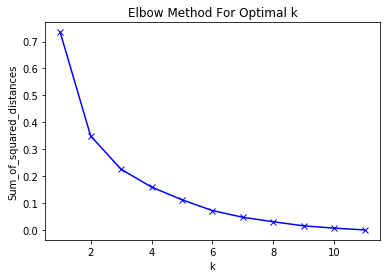

In [28]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the figure, we see a pretty clear elbow point at k = 2, indicating that 2 is the best number of clusters.

In [29]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1], dtype=int32)

## Results <a name="results"></a>

Here is the merged table with cluster labels for each district.

In [30]:
# add clustering labels
district_res_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kl_merged = KL

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kl_merged = kl_merged.join(district_res_sorted.set_index('District'), on='District')
#kl_merged.dropna(0, inplace=True)
#kl_merged['Cluster Labels'] = kl_merged['Cluster Labels'].astype('int64')
kl_merged.head() 

,District,Latitude,Longitude,Majority Race,Percentage,Majority Race No,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,LEMBAH PANTAI,3.109179,101.664066,Malay,62.11,0,0,Chinese Restaurant,Japanese Restaurant,Malay Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Restaurant,Seafood Restaurant,Indian Restaurant,Cantonese Restaurant
1,TITIWANGSA,3.153691,101.736048,Malay,70.48,0,1,Malay Restaurant,Asian Restaurant,Korean Restaurant,Chinese Restaurant,Seafood Restaurant,Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Middle Eastern Restaurant
2,CHERAS,3.098256,101.734837,Chinese,82.93,1,0,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Thai Restaurant,Malay Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Korean Restaurant,Seafood Restaurant,Indian Restaurant
3,SETIAWANGSA,3.185183,101.733304,Malay,61.08,0,0,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Restaurant,Thai Restaurant,Malay Restaurant,Dim Sum Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant
4,BUKIT BINTANG,3.139090,101.700725,Chinese,75.13,1,0,Indian Restaurant,Malay Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Thai Restaurant,South Indian Restaurant,French Restaurant,Korean Restaurant


#### Map of Kuala Lumpur with clustered information superimposed on top.

Let's create a map to visualize the clustered information of restaurants in district areas of Kuala Lumpur.

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['District'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters

#### Examine Clusters

Let's separate the table according to the Cluster Labels for ease of comparison and analysis.

Cluster 0:

In [38]:
kl_cluster0 = kl_merged.loc[kl_merged['Cluster Labels'] == 0, kl_merged.columns[[0] + [3] + list(range(6, kl_merged.shape[1]))]] 
kl_cluster0 

,District,Majority Race,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,LEMBAH PANTAI,Malay,0,Chinese Restaurant,Japanese Restaurant,Malay Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Restaurant,Seafood Restaurant,Indian Restaurant,Cantonese Restaurant
2,CHERAS,Chinese,0,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Thai Restaurant,Malay Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Korean Restaurant,Seafood Restaurant,Indian Restaurant
3,SETIAWANGSA,Malay,0,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Restaurant,Thai Restaurant,Malay Restaurant,Dim Sum Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant
4,BUKIT BINTANG,Chinese,0,Indian Restaurant,Malay Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Thai Restaurant,South Indian Restaurant,French Restaurant,Korean Restaurant
5,BATU,Malay,0,Chinese Restaurant,Asian Restaurant,Malay Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Thai Restaurant,Seafood Restaurant,Indian Restaurant,Cantonese Restaurant,Comfort Food Restaurant
6,KEPONG,Chinese,0,Chinese Restaurant,Asian Restaurant,Malay Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Halal Restaurant,Thai Restaurant,Cantonese Restaurant,Comfort Food Restaurant
7,SEPUTEH,Chinese,0,Chinese Restaurant,Asian Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Hotpot Restaurant,Malay Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Hong Kong Restaurant
10,BANDAR TUN RAZAK,Malay,0,Chinese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Cantonese Restaurant,Restaurant,Malay Restaurant,Dim Sum Restaurant,English Restaurant,Indian Restaurant,Vietnamese Restaurant


Cluster 1:

In [39]:
kl_cluster1 = kl_merged.loc[kl_merged['Cluster Labels'] == 1, kl_merged.columns[[0] + [3] + list(range(6, kl_merged.shape[1]))]]  
kl_cluster1

,District,Majority Race,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
1,TITIWANGSA,Malay,1,Malay Restaurant,Asian Restaurant,Korean Restaurant,Chinese Restaurant,Seafood Restaurant,Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Middle Eastern Restaurant
8,SEGAMBUT,Chinese,1,Malay Restaurant,Indian Restaurant,Asian Restaurant,Chinese Restaurant,Sushi Restaurant,Vietnamese Restaurant,Hakka Restaurant,Hunan Restaurant,Hotpot Restaurant,Hong Kong Restaurant
9,WANGSA MAJU,Malay,1,Malay Restaurant,Asian Restaurant,Chinese Restaurant,Restaurant,Halal Restaurant,Thai Restaurant,Indonesian Restaurant,Comfort Food Restaurant,Seafood Restaurant,Latin American Restaurant


We also able to identify the number of the first most common restaurant in each cluster. Thus, we can create a bar chart which may help us to find proper labels for each cluster.

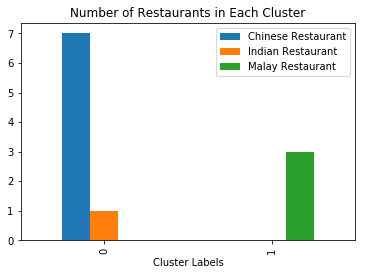

In [35]:
kl_clusters = kl_merged[['Cluster Labels','1st Most Common Restaurant', 'District']].groupby(['Cluster Labels','1st Most Common Restaurant'],as_index=False).count()
kl_clusters.rename(columns={'District':'Count'}, inplace=True)
kl_clusters = kl_clusters.groupby(['Cluster Labels','1st Most Common Restaurant']).aggregate(np.sum).unstack()
ax = kl_clusters.plot(kind='bar', title='Number of Restaurants in Each Cluster')
ax.legend(kl_clusters.columns.get_level_values(1).tolist())

When we examine above graph we can label each cluster as follows:  

Cluster 0 : Chinese Restaurants  
Cluster 1 : Malay Restaurants  

#### Map of Kuala Lumpur with clustered information and demography superimposed on top.

Let's create a map to visualize the clustered types of restaurants, together with demographic information in district areas of Kuala Lumpur.

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

map_clusters.choropleth(
    geo_data=KL_data,
    data=KL,
    columns=['District', 'Majority Race No'],
    key_on='feature.properties.Parliament',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Race: 0 as Malay, 1 as Chinese'
)

# add markers to the map
markers_colors = []
for lat, lon, district, race, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['District'], kl_merged['Majority Race'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(district) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters

## Discussion <a name="discussion"></a>

As mentioned earlier, Kuala Lumpur is one of the cities with a high population density in a narrow area. Our analysis shows that although there are a great number of restaurants in Kuala Lumpur, there are pockets of low restaurant density fairly close to city center like areas of Titiwangsa and Segambut, for example.

As from the map above, we can observe that four out of eight clustered areas labeled 0, which are having Chinese restaurants as the first common restaurant in their areas, are dominated by the Chinese group. Whereas in the clustered areas labeled 1, the majority race is the Malays group, therefore the first common type of restaurants is Malay restaurants. On the other hand, There are also a presence of Indian restaurants in smaller portion, which is reasonable too, as when we examine back the first table about the proportion of ethnic groups in Kuala Lumpur, we can see that the Indians is the third largest group, after the Malays and Chinese group, in which we did not observed from the map directly. A more detailed analysis could be done to relate the demographic information and type of restaurant more precisely. 

A more accurate information also can be obtained from government’s actual demographic data to correctly show the proportion of ethic groups in Kuala Lumpur, as the data used in this project is scraped from a site served for election purpose and containing the demographic data about the voters only. 

During the clustering process, K-means algorithm is used with a optimal value of 2. However, only 11 district coordinates are used. Moreover, the centers' coordinates are merely estimated by simple calculation of based on districts' boundaries. Therefore, for more detailed and accurate guidance, the data set can be expanded and the actual locations of district centers can be obtained by realistic approaches.

Purpose of this analysis is to only provide restaurant information on areas within Kuala Lumpur city (particularly their types) which may influenced by the ethnic groups stayed in Malaysia. The result shows that demography in Kuala Lumpur did influence the number of particular restaurants with some degree. Suggestion of type of a restaurant can be recommended as a starting point, and a more detailed analysis could be done to eventually result in location which has not only less nearby competition but also able to attract the attention of majority ethnic group in that area.


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Kuala Lumpur areas with information of restaurants in order to aid stakeholders in narrowing down the search for optimal location and a suitable type of restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs with different types of restaurants. Clustering of those locations was then performed in order to create major zones of interest by particular ethnic group, and to be utilized as starting points for final exploration by stakeholders. Hence, final decision on optimal restaurant location is able to made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone.